# Machine Learning: NN Algorithm

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
data1 shape: (345, 1776)
data2 shape: (345, 1776)
Epoch [1/100], Loss: 0.5044
Epoch [2/100], Loss: 0.4830
Epoch [3/100], Loss: 0.4780
Epoch [4/100], Loss: 0.4834
Epoch [5/100], Loss: 0.4927
Epoch [6/100], Loss: 0.4905
Epoch [7/100], Loss: 0.5066
Epoch [8/100], Loss: 0.4856
Epoch [9/100], Loss: 0.4896
Epoch [10/100], Loss: 0.4989
Epoch [11/100], Loss: 0.5055
Epoch [12/100], Loss: 0.4903
Epoch [13/100], Loss: 0.4936
Epoch [14/100], Loss: 0.4928
Epoch [15/100], Loss: 0.4754
Epoch [16/100], Loss: 0.4980
Epoch [17/100], Loss: 0.4779
Epoch [18/100], Loss: 0.4780
Epoch [19/100], Loss: 0.5031
Epoch [20/100], Loss: 0.4782
Epoch [21/100], Loss: 0.4810
Epoch [22/100], Loss: 0.4831
Epoch [23/100], Loss: 0.4854
Epoch [24/100], Loss: 0.4728
Epoch [25/100], Loss: 0.4799
Epoch [26/100], Loss: 0.4754
Epoch [27/100], Loss: 0.4698
Epoch [28/100], Loss: 0.4801
Epoch [29/100], 

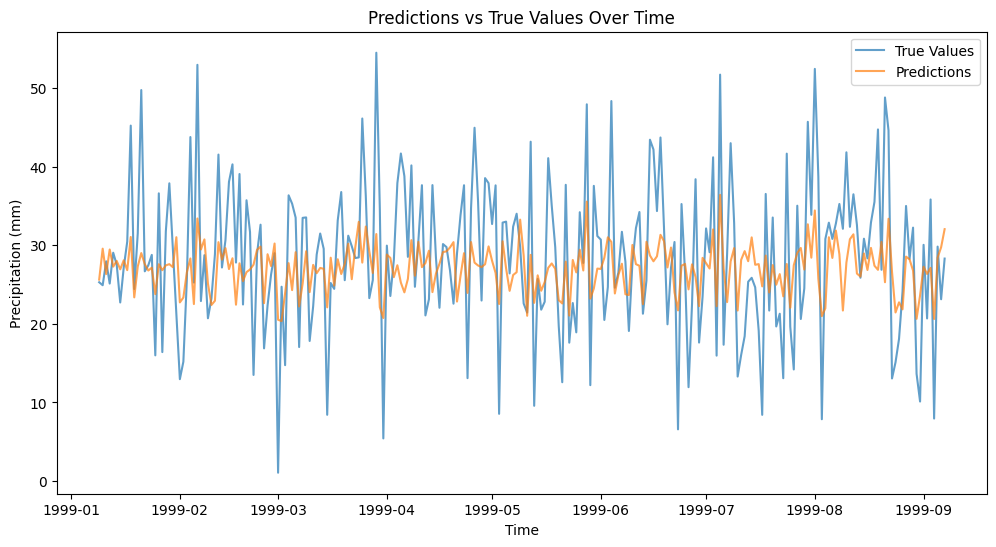

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


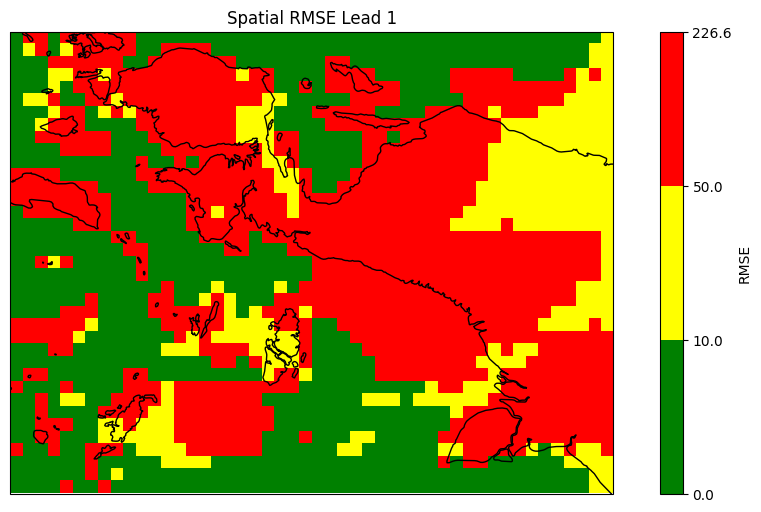

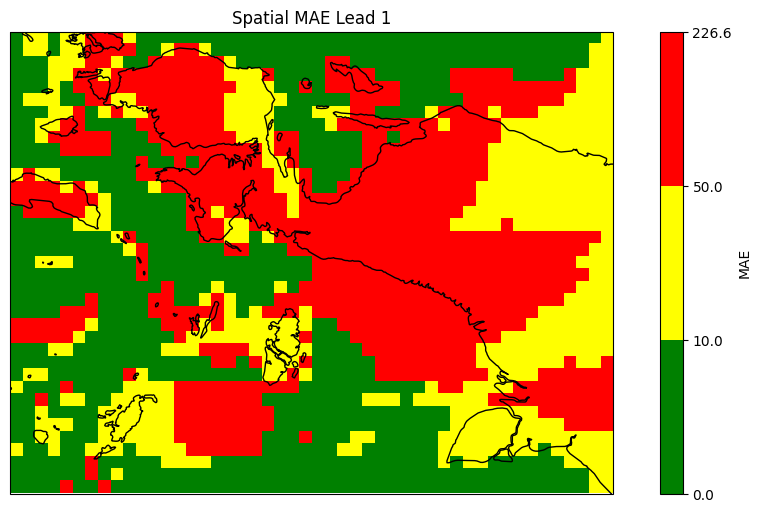

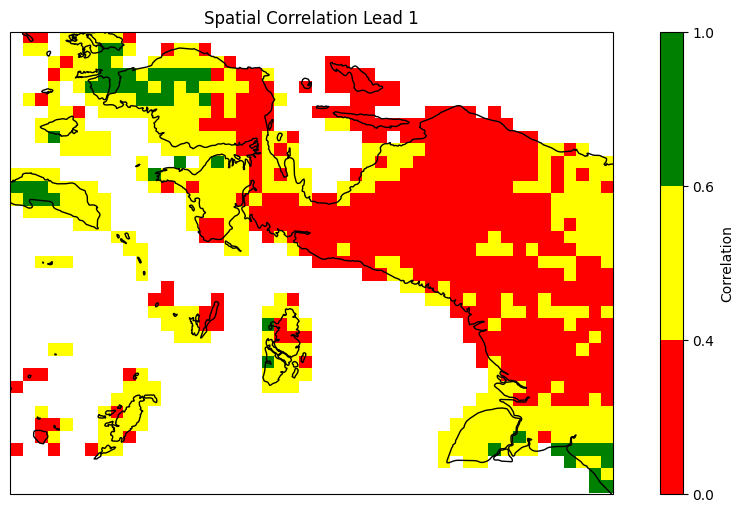

In [ ]:
!pip install cartopy
import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from google.colab import drive
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, ListedColormap

drive.mount('/content/drive/')
path = "/content/drive/My Drive/#IMPLEMENTASI/"

# Paths
leadin=1
pathout = path + "OUTPUT/"
#for leadin in range(1,4):
# Read data
nc_forecast = xr.open_dataset(path + f"CLIPPED_CFSV2_forecast_L{leadin}.nc")
nc_hindcast = xr.open_dataset(pathout + f"CLIPPED_CFSV2_hindcast_L{leadin}.nc")
nc_chirps = xr.open_dataset(pathout + f"CHIRPSPAPUA.nc")
# Align datasets
nc_chirps = nc_chirps.sel(X=slice(nc_forecast.X.min(), nc_forecast.X.max()), Y=slice(nc_forecast.Y.max(), nc_forecast.Y.min()))
nc_hindcast = nc_hindcast.rename({'S': 'T'})
nc_forecast = nc_forecast.rename({'S': 'T'})
nc_forecast = nc_forecast.sel(T=slice(nc_forecast.T.min(), nc_chirps.T.max()))
nc_chirps = nc_chirps.sel(T=slice(nc_forecast.T.min(), nc_forecast.T.max()))
#  nc_chirps = nc_chirps.sel(T=slice(nc_hindcast.T.min(), nc_hindcast.T.max()))

nc_chirps = nc_chirps.resample(T="7D").sum()
#nc_hindcast = nc_hindcast.resample(T="7D").sum()/4#-118
nc_forecast = nc_forecast.resample(T="7D").sum()/4#-118

#nc_forecast=nc_forecast.sel(T=nc_forecast["T.month"]==1)
#nc_chirps=nc_chirps.sel(T=nc_chirps["T.month"]==1)
nc_chirps['prcp'] = nc_chirps['prcp'].fillna(0)
#nc_hindcast['pr'] = nc_hindcast['pr'].fillna(0)
nc_forecast['pr'] = nc_forecast['pr'].fillna(0)

# Prepare data for training and testing
data1 = nc_chirps['prcp'].values.reshape((nc_chirps.dims['T'], -1))  # reanalysis
#data2 = nc_hindcast['pr'].values.reshape((nc_hindcast.dims['T'], -1))  # forecast lead1
data2 = nc_forecast['pr'].values.reshape((nc_forecast.dims['T'], -1))  # forecast lead1

print(f"data1 shape: {data1.shape}")
print(f"data2 shape: {data2.shape}")

scaler1 = StandardScaler()
scaler2 = StandardScaler()

data1 = scaler1.fit_transform(data1)
data2 = scaler2.fit_transform(data2)

X_train1, X_test1, y_train1, y_test1 = train_test_split(data2, data1, test_size=0.7, random_state=10)

# Convert to PyTorch tensors
X_train1 = torch.tensor(X_train1, dtype=torch.float32)
X_test1 = torch.tensor(X_test1, dtype=torch.float32)
y_train1 = torch.tensor(y_train1, dtype=torch.float32)
y_test1 = torch.tensor(y_test1, dtype=torch.float32)

# Create DataLoader with a smaller batch size
train_dataset = TensorDataset(X_train1, y_train1)
test_dataset = TensorDataset(X_test1, y_test1)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, input_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = X_train1.shape[1]
model = NeuralNetwork(input_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

#Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Save the model
model_path = f'{path}model.pth'
torch.save(model.state_dict(), model_path)

# Load the model
model.load_state_dict(torch.load(model_path))
model.eval()

# Make predictions on the test data
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        predictions.append(outputs.numpy())

predictions = np.vstack(predictions)

# Optionally, convert predictions back to xarray DataArray
predictions = predictions.reshape((len(predictions), nc_chirps.dims['Y'], nc_chirps.dims['X']))

# Create DataArray for predictions
#  predictions_da = xr.DataArray(predictions, dims=('T', 'Y', 'X'), coords={'T': nc_hindcast.T[:len(predictions)], 'Y': nc_hindcast.Y, 'X': nc_hindcast.X})
predictions_da = xr.DataArray(predictions, dims=('T', 'Y', 'X'), coords={'T': nc_forecast.T[:len(predictions)], 'Y': nc_forecast.Y, 'X': nc_forecast.X})

# Convert DataArray to Dataset
predictions_ds = predictions_da.to_dataset(name='prcp')

# Save the Dataset as a NetCDF file
output_path = f'{pathout}predictions.nc'
predictions_ds.to_netcdf(output_path)

# Evaluate the model
y_test_inv = scaler1.inverse_transform(y_test1.numpy().reshape(-1, nc_chirps.dims['Y'] * nc_chirps.dims['X']))
y_pred_inv = scaler2.inverse_transform(predictions.reshape(-1, nc_chirps.dims['Y'] * nc_chirps.dims['X']))

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
correlation = np.corrcoef(y_test_inv.flatten(), y_pred_inv.flatten())[0, 1]

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'Correlation: {correlation}')

# Plot the predictions and true values over time
time_index = nc_hindcast.T[:len(predictions)]
plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test_inv.mean(axis=1), label='True Values', alpha=0.7)
plt.plot(time_index, y_pred_inv.mean(axis=1), label='Predictions', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.title('Predictions vs True Values Over Time')
plt.legend()
plt.show()

# Calculate spatial metrics
spatial_rmse = np.sqrt(((y_test_inv - y_pred_inv) ** 2).mean(axis=0))
spatial_mae = np.abs(y_test_inv - y_pred_inv).mean(axis=0)

# Reshape spatial metrics to match the original data shape
spatial_rmse = spatial_rmse.reshape((nc_chirps.dims['Y'], nc_chirps.dims['X']))
spatial_mae = spatial_mae.reshape((nc_chirps.dims['Y'], nc_chirps.dims['X']))

# Calculate spatial correlation
def calc_correlation(y_true, y_pred):
    corr = np.zeros(y_true.shape[1])
    for i in range(y_true.shape[1]):
        corr[i] = np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1]
    return corr

spatial_corr = calc_correlation(y_test_inv, y_pred_inv).reshape((nc_chirps.dims['Y'], nc_chirps.dims['X']))

# Define custom colormap
colors_rmse_mae = ['green', 'yellow', 'red']
cmap_rmse_mae = ListedColormap(colors_rmse_mae)
boundaries_rmse_mae = [0, 10, 50, np.max([spatial_rmse.max(), spatial_mae.max()])]
norm_rmse_mae = BoundaryNorm(boundaries_rmse_mae, cmap_rmse_mae.N, clip=True)

colors_corr = ['red', 'yellow', 'green']
cmap_corr = ListedColormap(colors_corr)
boundaries_corr = [0, 0.4, 0.6, 1.0]
norm_corr = BoundaryNorm(boundaries_corr, cmap_corr.N, clip=True)

# Plot spatial RMSE with custom colormap and coastal line
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.imshow(spatial_rmse, origin='upper', extent=[nc_chirps.X.min(), nc_chirps.X.max(), nc_chirps.Y.min(), nc_chirps.Y.max()], cmap=cmap_rmse_mae, norm=norm_rmse_mae, transform=ccrs.PlateCarree())
plt.colorbar(im, ax=ax, orientation='vertical', label='RMSE')
plt.title(f'Spatial RMSE Lead {leadin}')
plt.show()

# Plot spatial MAE with custom colormap and coastal line
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.imshow(spatial_mae, origin='upper', extent=[nc_chirps.X.min(), nc_chirps.X.max(), nc_chirps.Y.min(), nc_chirps.Y.max()], cmap=cmap_rmse_mae, norm=norm_rmse_mae, transform=ccrs.PlateCarree())
plt.colorbar(im, ax=ax, orientation='vertical', label='MAE')
plt.title(f'Spatial MAE Lead {leadin}')
plt.show()

# Plot spatial correlation with custom colormap and coastal line
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
im = ax.imshow(spatial_corr, origin='upper', extent=[nc_chirps.X.min(), nc_chirps.X.max(), nc_chirps.Y.min(), nc_chirps.Y.max()], cmap=cmap_corr, norm=norm_corr, transform=ccrs.PlateCarree())
plt.colorbar(im, ax=ax, orientation='vertical', label='Correlation')
plt.title(f'Spatial Correlation Lead {leadin}')
plt.show()


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
---------------------------------
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
---------------------------------
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

------------- 
 ini data1:979

------------- 
 ini data2:979

------------- 
 ini data3:345

------------- 
 ini data4:345
this is: 1776
torch.Size([979, 1776])
Epoch [1/100], Loss: 117.2904
Epoch [2/100], Loss: 109.6574
Epoch [3/100], Loss: 109.1031
Epoch [4/100], Loss: 108.3116
Epoch [5/100], Loss: 107.0858
Epoch [6/100], Loss: 105.3791
Epoch [7/100], Loss: 103.0278
Epoch [8/100], Loss: 100.1280
Epoch [9/100], Loss: 96.8053
Epoch [10/100], Loss: 93.2895
Epoch [11/100], Loss: 89.915

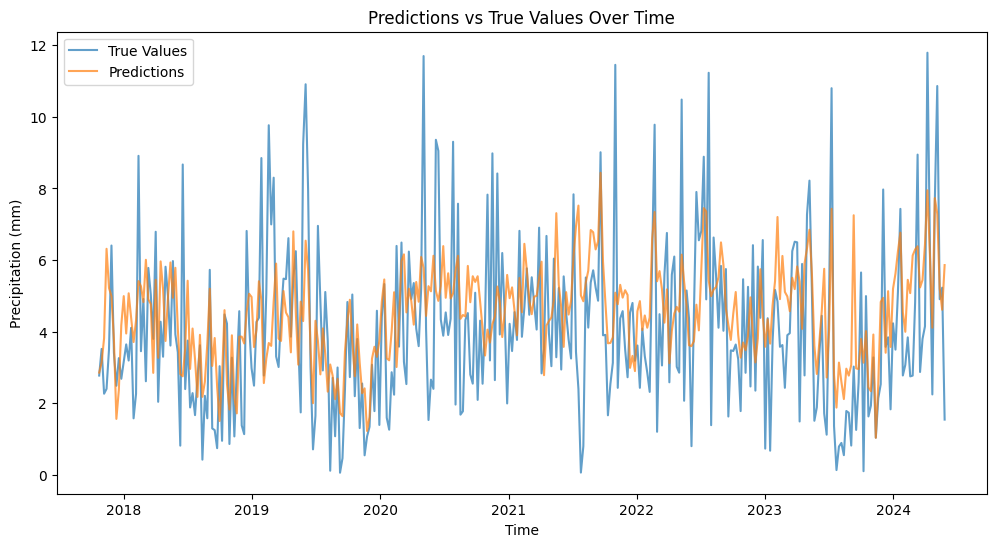

In [ ]:
!pip install cartopy
import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from google.colab import drive
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, ListedColormap

drive.mount('/content/drive/')
path = "/content/drive/My Drive/#IMPLEMENTASI/"

# Paths
leadin=1
pathout = path + "OUTPUT/"
#for leadin in range(1,4):
# Read data
nc_forecast = xr.open_dataset(path + f"CLIPPED_CFSV2_forecast_L{leadin}.nc")
nc_hindcast = xr.open_dataset(path + f"CLIPPED_CFSV2_hindcast_L{leadin}.nc")
nc_chirps = xr.open_dataset(pathout + f"CHIRPSPAPUA.nc")
nc_forecast = nc_forecast.sortby(['X', 'Y'])
nc_hindcast = nc_hindcast.sortby(['X', 'Y'])
nc_chirps = nc_chirps.sortby(['X', 'Y'])
nc_chirps

#SUSUN DATA TRAINING
nc_chirps = nc_chirps.sel(X=slice(nc_forecast.X.min(), nc_forecast.X.max()), Y=slice(nc_forecast.Y.min(), nc_forecast.Y.max()))
nc_hindcast = nc_hindcast.rename({'S': 'T'})
nc_forecast = nc_forecast.rename({'S': 'T'})


#nc_forecast['pr']=nc_forecast['pr']#*86400
#nc_hindcast['pr']=nc_hindcast['pr']#*86400

#POTONG DIMENSI WAKTU DATA TRAINING DAN TESTING
nc_forecast = nc_forecast.sel(T=slice(nc_forecast.T.min(), nc_chirps.T.max()))
nc_chirpsf = nc_chirps.sel(T=slice(nc_forecast.T.min(), nc_forecast.T.max()))
nc_chirpsh = nc_chirps.sel(T=slice(nc_hindcast.T.min(), nc_hindcast.T.max()))
#nc_chirps = nc_chirps.sel(T=slice(nc_hindcast.T.min(), nc_hindcast.T.max()))

#RESAMPLE 7 HARIAN
nc_chirpsf = nc_chirpsf.resample(T="7D").sum()
nc_chirpsh = nc_chirpsh.resample(T="7D").sum()
nc_hindcast = nc_hindcast.resample(T="7D").sum()/4#-118
nc_forecast = nc_forecast.resample(T="7D").sum()/4#-118

#nc_forecast=nc_forecast.sel(T=nc_forecast["T.month"]==1)
#nc_chirps=nc_chirps.sel(T=nc_chirps["T.month"]==1)

nc_chirpsf['prcp'] = nc_chirps['prcp'].fillna(0)
nc_chirpsh['prcp'] = nc_chirps['prcp'].fillna(0)
nc_hindcast['pr'] = nc_hindcast['pr'].fillna(0)
nc_forecast['pr'] = nc_forecast['pr'].fillna(0)

# Prepare data for training and testing
data1 = nc_chirpsh['prcp'].values.reshape((nc_chirpsh.dims['T'], -1))  # chirps
data2 = nc_hindcast['pr'].values.reshape((nc_hindcast.dims['T'], -1))  # forecast lead1
data3 = nc_forecast['pr'].values.reshape((nc_forecast.dims['T'], -1))  # forecast lead1
data4 = nc_chirpsf['prcp'].values.reshape((nc_chirpsf.dims['T'], -1))  # chirps
print("---------------------------------")
print(data1)
#print(f"data2 shape: {data2.shape}")
#scaler1 = StandardScaler()
#scaler2 = StandardScaler()
#scaler3 = StandardScaler()
#scaler4 = StandardScaler()
#
#data1 = scaler1.fit_transform(data1)#CHIRPSTRAIN
#data2 = scaler2.fit_transform(data2)#HINDCAST
#data3 = scaler3.fit_transform(data3)#FORECAST
#data4 = scaler4.fit_transform(data3)#CHIRPSTEST
print("---------------------------------")
print(data1)
print(f"\n------------- \n ini data1:{len(data1)}")
print(f"\n------------- \n ini data2:{len(data2)}")
print(f"\n------------- \n ini data3:{len(data3)}")
print(f"\n------------- \n ini data4:{len(data4)}")

X_train1=data2
y_train1=data1
X_test1=data3
y_test1=data4

#X_train1, X_test1, y_train1, y_test1 = train_test_split(data2, data1, test_size=0.7, random_state=10)

#print(f"\n xtrain adlaah: {X_train1}")
#print(f"\n ytrain adlaah: {y_train1}")
#
# Convert to PyTorch tensors
X_train1 = torch.tensor(X_train1, dtype=torch.float32)
X_test1 = torch.tensor(X_test1, dtype=torch.float32)
y_train1 = torch.tensor(y_train1, dtype=torch.float32)
y_test1 = torch.tensor(y_test1, dtype=torch.float32)

# Create DataLoader with a smaller batch size
train_dataset = TensorDataset(X_train1, y_train1)
test_dataset = TensorDataset(X_test1, y_test1)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,)
print(train_loader)
print(test_loader)
# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, input_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
input_size = X_train1.shape[1]
model = NeuralNetwork(input_size)
print(f"this is: {input_size}")
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print(X_train1.shape)
#Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

from datetime import datetime, timedelta, date
harini=str(date.today()-timedelta(days=1)).replace("-","")

# Save the model
model_path = f'{path}modelNNLINEAR_update_{harini}.pth'
torch.save(model.state_dict(), model_path)

# Load the model
model.load_state_dict(torch.load(model_path))
model.eval()

# Make predictions on the test data
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        predictions.append(outputs.numpy())

predictions = np.vstack(predictions)
print(predictions)


predictions = predictions.reshape((len(predictions), nc_chirpsf.dims['Y'], nc_chirpsf.dims['X']))

# Create DataArray for predictions
predictions_da = xr.DataArray(predictions, dims=('T', 'Y', 'X'), coords={'T': nc_chirpsf.T[:len(predictions)], 'Y': nc_hindcast.Y, 'X': nc_hindcast.X})
predictions = predictions.reshape((len(predictions), nc_chirpsf.dims['Y'], nc_chirpsf.dims['X']))

# Convert DataArray to Dataset
predictions_ds = predictions_da.to_dataset(name='prcp')
predictions_ds

################################################################################
################################################################################
################################################################################

# Evaluate the model
#y_test_inv = scaler1.inverse_transform(y_test1.numpy().reshape(-1, nc_chirps.dims['Y'] * nc_chirps.dims['X']))
#y_pred_inv = scaler2.inverse_transform(predictions.reshape(-1, nc_chirps.dims['Y'] * nc_chirps.dims['X']))
y_test_inv = y_test1.numpy().reshape(-1, nc_chirpsf.dims['Y'] * nc_chirpsf.dims['X'])
y_pred_inv = predictions.reshape(-1, nc_chirpsf.dims['Y'] * nc_chirpsf.dims['X'])

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
correlation = np.corrcoef(y_test_inv.flatten(), y_pred_inv.flatten())[0, 1]

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'Correlation: {correlation}')

# Plot the predictions and true values over time
time_index = nc_forecast.T[:len(predictions)]
plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test_inv.mean(axis=1), label='True Values', alpha=0.7)
plt.plot(time_index, y_pred_inv.mean(axis=1), label='Predictions', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.title('Predictions vs True Values Over Time')
plt.legend()
plt.show()

# Calculate spatial metrics
spatial_rmse = np.sqrt(((y_test_inv - y_pred_inv) ** 2).mean(axis=0))
spatial_mae = np.abs(y_test_inv - y_pred_inv).mean(axis=0)
#
## Reshape spatial metrics to match the original data shape
#spatial_rmse = spatial_rmse.reshape((nc_chirpsf.dims['Y'], nc_chirpsf.dims['X']))
#spatial_mae = spatial_mae.reshape((nc_chirpsf.dims['Y'], nc_chirpsf.dims['X']))
#
## Calculate spatial correlation
#def calc_correlation(y_true, y_pred):
#    corr = np.zeros(y_true.shape[1])
#    for i in range(y_true.shape[1]):
#        corr[i] = np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1]
#    return corr
#
#spatial_corr = calc_correlation(y_test_inv, y_pred_inv).reshape((nc_chirps.dims['Y'], nc_chirps.dims['X']))**2
#
## Define custom colormap
#colors_rmse_mae = ['green', 'yellow', 'red']
#cmap_rmse_mae = ListedColormap(colors_rmse_mae)
#boundaries_rmse_mae = [0, 10, 50, np.max([spatial_rmse.max(), spatial_mae.max()])]
#norm_rmse_mae = BoundaryNorm(boundaries_rmse_mae, cmap_rmse_mae.N, clip=True)
#
#colors_corr = ['red', 'yellow', 'green']
#cmap_corr = ListedColormap(colors_corr)
#boundaries_corr = [0, 0.4, 0.6, 1.0]
#norm_corr = BoundaryNorm(boundaries_corr, cmap_corr.N, clip=True)
#
## Plot spatial RMSE with custom colormap and coastal line
#plt.figure(figsize=(12, 6))
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.coastlines()
#im = ax.imshow(spatial_rmse, origin='upper', extent=[nc_chirpsf.X.min(), nc_chirpsf.X.max(), nc_chirpsf.Y.min(), nc_chirpsf.Y.max()], cmap=cmap_rmse_mae, norm=norm_rmse_mae, transform=ccrs.PlateCarree())
#plt.colorbar(im, ax=ax, orientation='vertical', label='RMSE')
#plt.title(f'Spatial RMSE Lead {leadin}')
#plt.show()
#
## Plot spatial MAE with custom colormap and coastal line
#plt.figure(figsize=(12, 6))
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.coastlines()
#im = ax.imshow(spatial_mae, origin='upper', extent=[nc_chirpsf.X.min(), nc_chirpsf.X.max(), nc_chirpsf.Y.min(), nc_chirpsf.Y.max()], cmap=cmap_rmse_mae, norm=norm_rmse_mae, transform=ccrs.PlateCarree())
#plt.colorbar(im, ax=ax, orientation='vertical', label='MAE')
#plt.title(f'Spatial MAE Lead {leadin}')
#plt.show()
#
## Plot spatial correlation with custom colormap and coastal line
#plt.figure(figsize=(12, 6))
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.coastlines()
#im = ax.imshow(spatial_corr, origin='upper', extent=[nc_chirpsf.X.min(), nc_chirpsf.X.max(), nc_chirpsf.Y.min(), nc_chirpsf.Y.max()], cmap=cmap_corr, norm=norm_corr, transform=ccrs.PlateCarree())
#plt.colorbar(im, ax=ax, orientation='vertical', label='Correlation')
#plt.title(f'Spatial R2 Lead {leadin}')
#plt.show()

In [ ]:
import pandas as pd
import os

workdir=os.getcwd()+"/"
df_list = []
output_excel_file=workdir+"yourfile.xlsx"
for csv in workdir:
  if csv.endswith(".csv"):
    df = pd.read_csv(csv_file)
    df_list.append(df)
    merged_df = pd.concat(df_list, ignore_index=True)
    merged_df.to_excel(output_excel_file, sheet_name="Result", index=False)


In [ ]:
y_test1
scaler2.inverse_transform(predictions)

ValueError: Found array with dim 3. None expected <= 2.

In [ ]:
#y_test_inv
#predictions_ds.prcp
#predictions_ds1=predictions_ds.isel(T=1)
#predictions_ds1['prcp']=predictions_ds1['prcp']**2
#predictions_ds1.prcp.plot()
test_dataset

In [ ]:
# Evaluate the model
#y_test_inv = scaler1.inverse_transform(y_test1.numpy().reshape(-1, nc_chirpsf.dims['Y'] * nc_chirpsf.dims['X']))
#y_pred_inv = scaler2.inverse_transform(predictions.reshape(-1, nc_chirpsf.dims['Y'] * nc_chirpsf.dims['X']))

#predictions = y_pred_inv.reshape((len(y_pred_inv), nc_chirpsf.dims['Y'], nc_chirpsf.dims['X']))

# Create DataArray for predictions
#  predictions_da = xr.DataArray(predictions, dims=('T', 'Y', 'X'), coords={'T': nc_hindcast.T[:len(predictions)], 'Y': nc_hindcast.Y, 'X': nc_hindcast.X})
#predictions_da = xr.DataArray(predictions, dims=('T', 'Y', 'X'), coords={'T': nc_forecast.T[:len(predictions)], 'Y': nc_forecast.Y, 'X': nc_forecast.X})

#predictions = []
#with torch.no_grad():
#    for inputs, _ in test_loader:
#        outputs = model(inputs)
#        predictions.append(outputs.numpy())
#
#predictions = np.vstack(predictions)
#print(predictions)
#
#
#predictions = predictions.reshape((len(predictions), nc_chirps.dims['Y'], nc_chirps.dims['X']))
#
## Create DataArray for predictions
##  predictions_da = xr.DataArray(predictions, dims=('T', 'Y', 'X'), coords={'T': nc_hindcast.T[:len(predictions)], 'Y': nc_hindcast.Y, 'X': nc_hindcast.X})
#predictions_da = xr.DataArray(predictions, dims=('T', 'Y', 'X'), coords={'T': nc_chirpsf.T[:len(predictions)], 'Y': nc_chirpsf.Y, 'X': nc_chirpsf.X})
#
## Convert DataArray to Dataset
#predictions_ds = predictions_da.to_dataset(name='prcp')
##predictions_ds
#
## Convert DataArray to Dataset
#predictions_ds = predictions_da.to_dataset(name='prcp')
#coba=predictions_ds.isel(T=5)
#coba['prcp']=coba['prcp']**2
#coba['prcp']=coba['prcp']
#coba.prcp.plot()


array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          2.8257596 ,  1.5965915 ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          3.2449164 ,  3.3719568 ],
        [ 0.        ,  0.        ,  0.        , ...,  1.9163975 ,
          4.682961  ,  3.6209323 ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.8136716 , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          3.5799    ,  8.768424  ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          7.292936  ,  9.4073105 ],
        [ 0.        ,  0.        ,  0.        , ...,  5.089308  ,
          7.3058653 ,  8.898979  ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

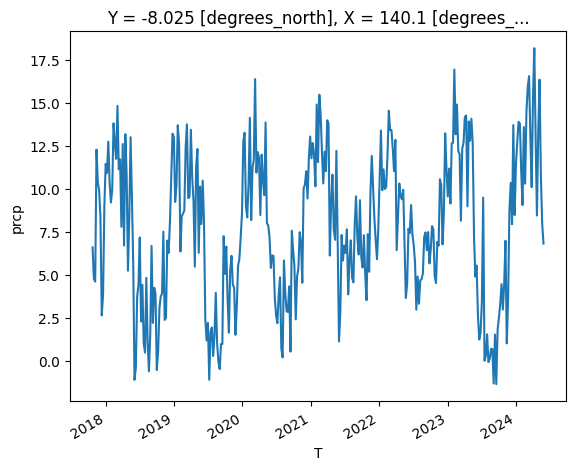

In [ ]:

#predictions_ds1=predictions_ds.isel(T=5)
#predictions_ds1['prcp']=predictions_ds1['prcp']**2/4
#predictions_ds1.prcp.plot()
#y_test_inv
#predictions_ds
predictions_ds1=predictions_ds.sel(X=140,Y=-8,method="nearest")
predictions_ds1['prcp']=predictions_ds1['prcp']
predictions_ds1.prcp.plot()

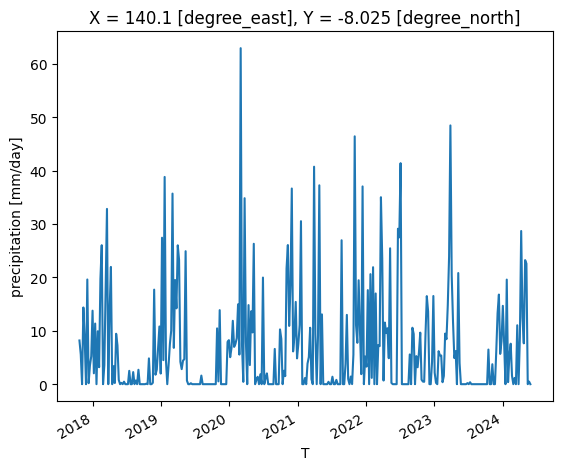

In [ ]:
nc_chirpsf1=nc_chirpsf.sel(X=140,Y=-8,method="nearest")
nc_chirpsf1.prcp.plot()


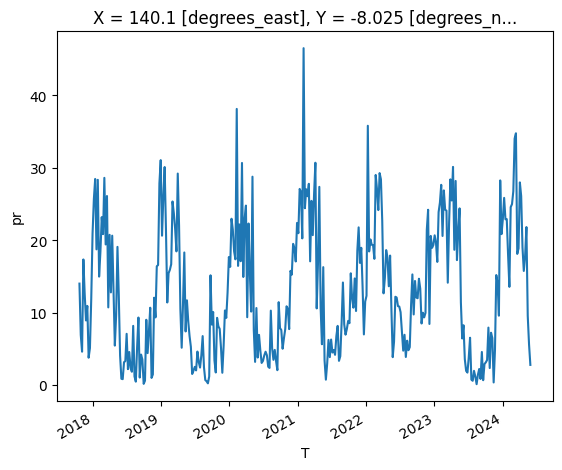

In [ ]:
nc_forecast1=nc_forecast.sel(X=140,Y=-8,method="nearest")
nc_forecast1['pr']=nc_forecast1['pr']/4
nc_forecast1.pr.plot()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
data1 shape: (345, 1776)
data2 shape: (345, 1776)
RMSE: 59.50864028930664
MAE: 37.6748046875
Correlation: 0.19294286498532895


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


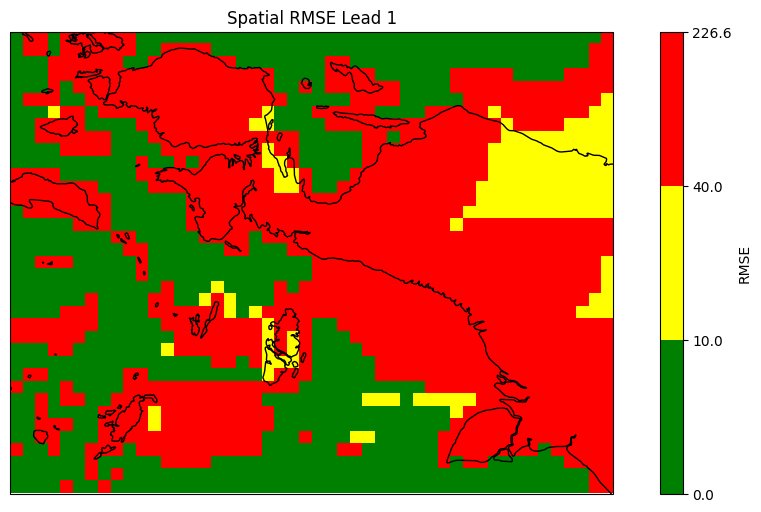

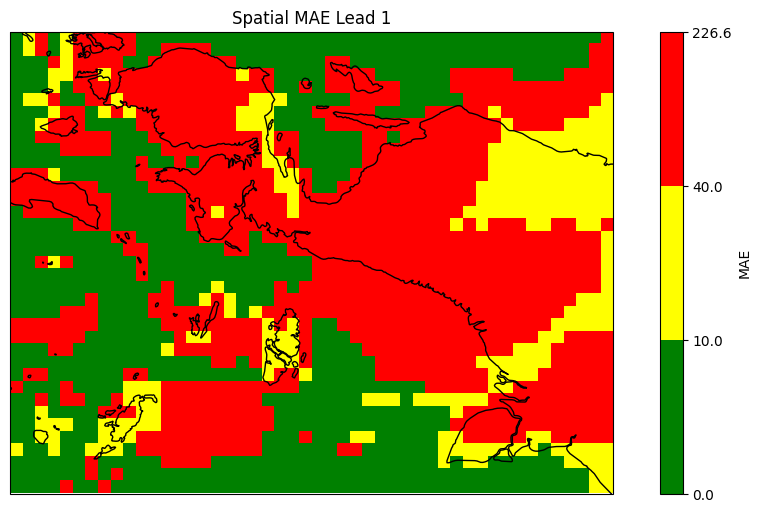

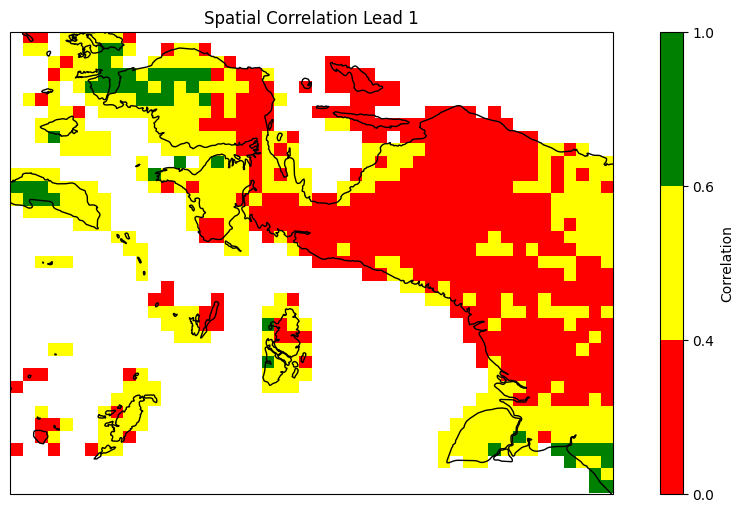

data1 shape: (344, 1776)
data2 shape: (344, 1776)
RMSE: 55.90922546386719
MAE: 35.36591720581055
Correlation: 0.19016046672711126


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


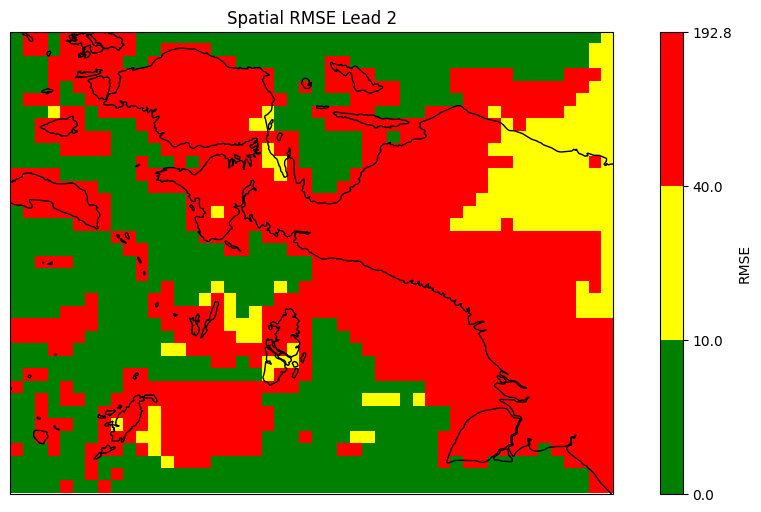

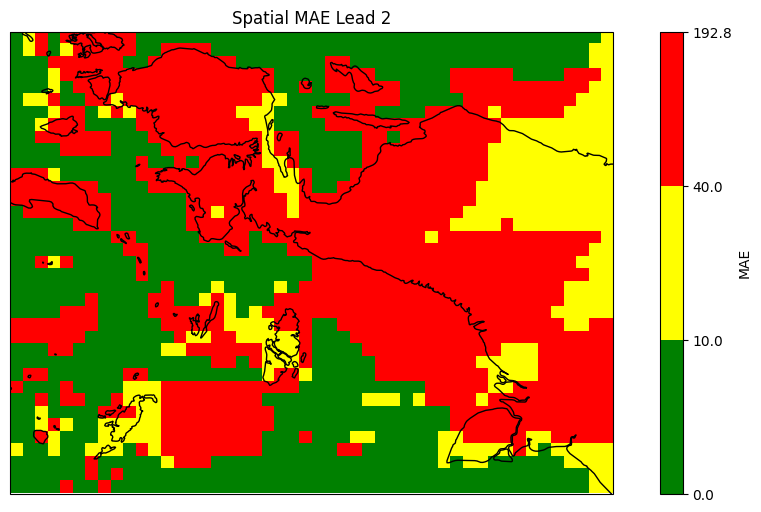

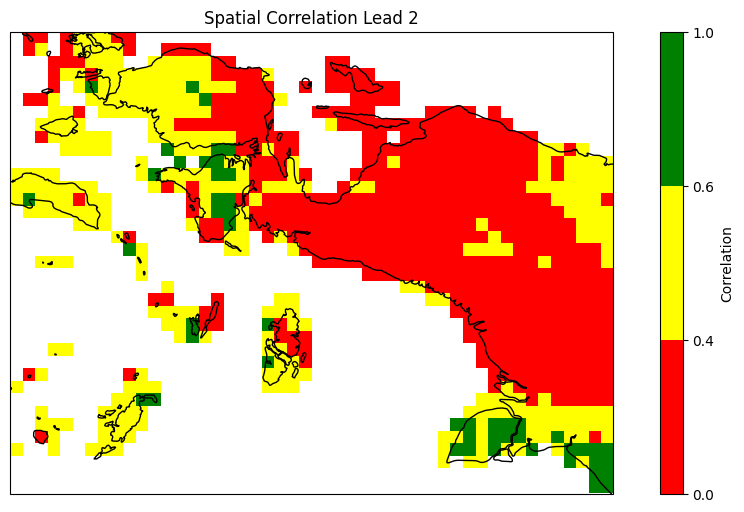

data1 shape: (343, 1776)
data2 shape: (343, 1776)
RMSE: 53.9793701171875
MAE: 34.175621032714844
Correlation: 0.1876431172669035


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


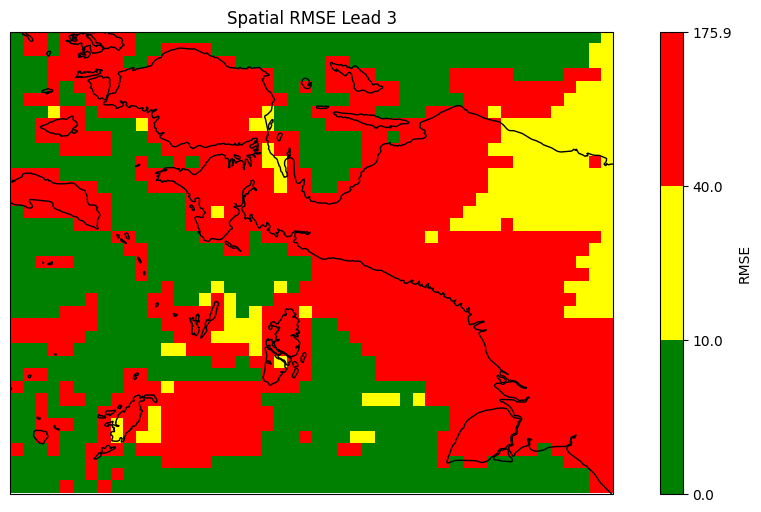

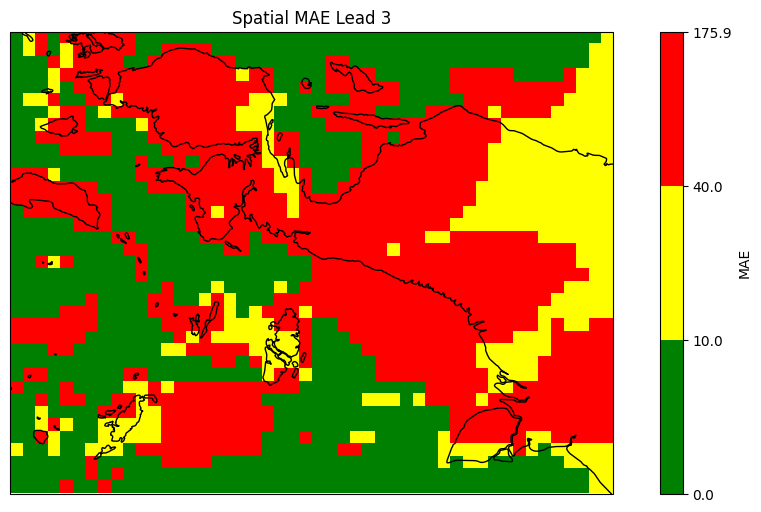

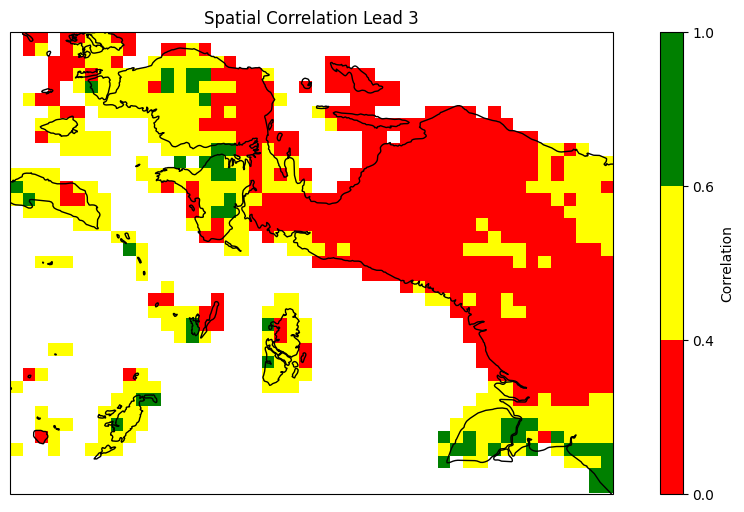

In [ ]:
import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from google.colab import drive
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm, ListedColormap

drive.mount('/content/drive/')
path = "/content/drive/My Drive/#IMPLEMENTASI/"

# Paths
#leadin=1
pathout = path + "OUTPUT/"
for leadin in range(1,4):
# Read data
  nc_forecast = xr.open_dataset(path + f"CLIPPED_CFSV2_forecast_L{leadin}.nc")
  nc_hindcast = xr.open_dataset(pathout + f"CLIPPED_CFSV2_hindcast_L{leadin}.nc")
  nc_chirps = xr.open_dataset(pathout + f"CHIRPSPAPUA.nc")

  # Align datasets
  nc_chirps = nc_chirps.sel(X=slice(nc_forecast.X.min(), nc_forecast.X.max()), Y=slice(nc_forecast.Y.max(), nc_forecast.Y.min()))
  nc_hindcast = nc_hindcast.rename({'S': 'T'})
  nc_forecast = nc_forecast.rename({'S': 'T'})
  nc_forecast = nc_forecast.sel(T=slice(nc_forecast.T.min(), nc_chirps.T.max()))
  nc_chirps = nc_chirps.sel(T=slice(nc_forecast.T.min(), nc_forecast.T.max()))
  #  nc_chirps = nc_chirps.sel(T=slice(nc_hindcast.T.min(), nc_hindcast.T.max()))

  nc_chirps = nc_chirps.resample(T="7D").sum()
  #nc_hindcast = nc_hindcast.resample(T="7D").sum()/4#-118
  nc_forecast = nc_forecast.resample(T="7D").sum()/4#-118

  nc_chirps['prcp'] = nc_chirps['prcp'].fillna(0)
  #nc_hindcast['pr'] = nc_hindcast['pr'].fillna(0)
  nc_forecast['pr'] = nc_forecast['pr'].fillna(0)

  # Prepare data for training and testing
  data1 = nc_chirps['prcp'].values.reshape((nc_chirps.dims['T'], -1))  # reanalysis
  #data2 = nc_hindcast['pr'].values.reshape((nc_hindcast.dims['T'], -1))  # forecast lead1
  data2 = nc_forecast['pr'].values.reshape((nc_forecast.dims['T'], -1))  # forecast lead1

  print(f"data1 shape: {data1.shape}")
  print(f"data2 shape: {data2.shape}")

  scaler1 = StandardScaler()
  scaler2 = StandardScaler()

  data1 = scaler1.fit_transform(data1)
  data2 = scaler2.fit_transform(data2)

  X_train1, X_test1, y_train1, y_test1 = train_test_split(data2, data1, test_size=0.7, random_state=10)

  # Convert to PyTorch tensors
  X_train1 = torch.tensor(X_train1, dtype=torch.float32)
  X_test1 = torch.tensor(X_test1, dtype=torch.float32)
  y_train1 = torch.tensor(y_train1, dtype=torch.float32)
  y_test1 = torch.tensor(y_test1, dtype=torch.float32)

  # Create DataLoader with a smaller batch size
  train_dataset = TensorDataset(X_train1, y_train1)
  test_dataset = TensorDataset(X_test1, y_test1)

  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

  # Define the model
  class NeuralNetwork(nn.Module):
      def __init__(self, input_size):
          super(NeuralNetwork, self).__init__()
          self.fc1 = nn.Linear(input_size, 256)
          self.fc2 = nn.Linear(256, 64)
          self.fc3 = nn.Linear(64, input_size)

      def forward(self, x):
          x = torch.relu(self.fc1(x))
          x = torch.relu(self.fc2(x))
          x = self.fc3(x)
          return x

  input_size = X_train1.shape[1]
  model = NeuralNetwork(input_size)

  # Define the loss function and optimizer
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.0001)

  # Train the model
  #num_epochs = 100
  #for epoch in range(num_epochs):
  #    model.train()
  #    running_loss = 0.0
  #    for inputs, targets in train_loader:
  #        optimizer.zero_grad()
  #        outputs = model(inputs)
  #        loss = criterion(outputs, targets)
  #        loss.backward()
  #        optimizer.step()
  #        running_loss += loss.item()
  #    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

  # Save the model
  model_path = f'{path}model.pth'
  #torch.save(model.state_dict(), model_path)

  # Load the model
  model.load_state_dict(torch.load(model_path))
  model.eval()

  # Make predictions on the test data
  predictions = []
  with torch.no_grad():
      for inputs, _ in test_loader:
          outputs = model(inputs)
          predictions.append(outputs.numpy())

  predictions = np.vstack(predictions)

  # Optionally, convert predictions back to xarray DataArray
  predictions = predictions.reshape((len(predictions), nc_chirps.dims['Y'], nc_chirps.dims['X']))

  # Create DataArray for predictions
  #  predictions_da = xr.DataArray(predictions, dims=('T', 'Y', 'X'), coords={'T': nc_hindcast.T[:len(predictions)], 'Y': nc_hindcast.Y, 'X': nc_hindcast.X})
  predictions_da = xr.DataArray(predictions, dims=('T', 'Y', 'X'), coords={'T': nc_forecast.T[:len(predictions)], 'Y': nc_forecast.Y, 'X': nc_forecast.X})

  # Convert DataArray to Dataset
  predictions_ds = predictions_da.to_dataset(name='prcp')

  # Save the Dataset as a NetCDF file
  output_path = f'{pathout}predictions.nc'
  predictions_ds.to_netcdf(output_path)

  # Evaluate the model
  #y_test_inv = nc_chirps['prcp'].values.reshape((nc_chirps.dims['T'], -1))
  #y_pred_inv = nc_forecast['pr'].values.reshape((nc_forecast.dims['T'], -1))
  # Evaluate the model
  y_test_inv = scaler1.inverse_transform(y_test1.numpy().reshape(-1, nc_chirps.dims['Y'] * nc_chirps.dims['X']))
  y_pred_inv = scaler2.inverse_transform(predictions.reshape(-1, nc_chirps.dims['Y'] * nc_chirps.dims['X']))


  # Calculate metrics
  rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
  mae = mean_absolute_error(y_test_inv, y_pred_inv)
  correlation = np.corrcoef(y_test_inv.flatten(), y_pred_inv.flatten())[0, 1]

  print(f'RMSE: {rmse}')
  print(f'MAE: {mae}')
  print(f'Correlation: {correlation}')

  # Plot the predictions and true values over time
  #time_index = nc_hindcast.T[:len(predictions)]
  #plt.figure(figsize=(12, 6))
  #plt.plot(time_index, y_test_inv.mean(axis=1), label='True Values', alpha=0.7)
  #plt.plot(time_index, y_pred_inv.mean(axis=1), label='Predictions', alpha=0.7)
  #plt.xlabel('Time')
  #plt.ylabel('Precipitation (mm)')
  #plt.title('Predictions vs True Values Over Time')
  #plt.legend()
  #plt.show()

  # Calculate spatial metrics
  spatial_rmse = np.sqrt(((y_test_inv - y_pred_inv) ** 2).mean(axis=0))
  spatial_mae = np.abs(y_test_inv - y_pred_inv).mean(axis=0)

  # Reshape spatial metrics to match the original data shape
  spatial_rmse = spatial_rmse.reshape((nc_chirps.dims['Y'], nc_chirps.dims['X']))
  spatial_mae = spatial_mae.reshape((nc_chirps.dims['Y'], nc_chirps.dims['X']))

  # Calculate spatial correlation
  def calc_correlation(y_true, y_pred):
      corr = np.zeros(y_true.shape[1])
      for i in range(y_true.shape[1]):
          corr[i] = np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1]
      return corr

  spatial_corr = calc_correlation(y_test_inv, y_pred_inv).reshape((nc_chirps.dims['Y'], nc_chirps.dims['X']))

  # Define custom colormap
  colors_rmse_mae = ['green', 'yellow', 'red']
  cmap_rmse_mae = ListedColormap(colors_rmse_mae)
  boundaries_rmse_mae = [0, 10, 40, np.max([spatial_rmse.max(), spatial_mae.max()])]
  norm_rmse_mae = BoundaryNorm(boundaries_rmse_mae, cmap_rmse_mae.N, clip=True)

  colors_corr = ['red', 'yellow', 'green']
  cmap_corr = ListedColormap(colors_corr)
  boundaries_corr = [0, 0.4, 0.6, 1.0]
  norm_corr = BoundaryNorm(boundaries_corr, cmap_corr.N, clip=True)

  # Plot spatial RMSE with custom colormap and coastal line
  plt.figure(figsize=(12, 6))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  im = ax.imshow(spatial_rmse, origin='upper', extent=[nc_chirps.X.min(), nc_chirps.X.max(), nc_chirps.Y.min(), nc_chirps.Y.max()], cmap=cmap_rmse_mae, norm=norm_rmse_mae, transform=ccrs.PlateCarree())
  plt.colorbar(im, ax=ax, orientation='vertical', label='RMSE')
  plt.title(f'Spatial RMSE Lead {leadin}')
  plt.show()

  # Plot spatial MAE with custom colormap and coastal line
  plt.figure(figsize=(12, 6))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  im = ax.imshow(spatial_mae, origin='upper', extent=[nc_chirps.X.min(), nc_chirps.X.max(), nc_chirps.Y.min(), nc_chirps.Y.max()], cmap=cmap_rmse_mae, norm=norm_rmse_mae, transform=ccrs.PlateCarree())
  plt.colorbar(im, ax=ax, orientation='vertical', label='MAE')
  plt.title(f'Spatial MAE Lead {leadin}')
  plt.show()

  # Plot spatial correlation with custom colormap and coastal line
  plt.figure(figsize=(12, 6))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  im = ax.imshow(spatial_corr, origin='upper', extent=[nc_chirps.X.min(), nc_chirps.X.max(), nc_chirps.Y.min(), nc_chirps.Y.max()], cmap=cmap_corr, norm=norm_corr, transform=ccrs.PlateCarree())
  plt.colorbar(im, ax=ax, orientation='vertical', label='Correlation')
  plt.title(f'Spatial Correlation Lead {leadin}')
  plt.show()


#HIDE

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
data1 shape: (979, 1, 37, 48)
data2 shape: (979, 1, 37, 48)
Epoch [1/100], Loss: 0.4704
Epoch [2/100], Loss: 0.4556
Epoch [3/100], Loss: 0.4371
Epoch [4/100], Loss: 0.4220
Epoch [5/100], Loss: 0.4127
Epoch [6/100], Loss: 0.4057
Epoch [7/100], Loss: 0.4010
Epoch [8/100], Loss: 0.3949
Epoch [9/100], Loss: 0.3913
Epoch [10/100], Loss: 0.3864
Epoch [11/100], Loss: 0.3825
Epoch [12/100], Loss: 0.3775
Epoch [13/100], Loss: 0.3733
Epoch [14/100], Loss: 0.3716
Epoch [15/100], Loss: 0.3685
Epoch [16/100], Loss: 0.3668
Epoch [17/100], Loss: 0.3626
Epoch [18/100], Loss: 0.3601
Epoch [19/100], Loss: 0.3572
Epoch [20/100], Loss: 0.3543
Epoch [21/100], Loss: 0.3505
Epoch [22/100], Loss: 0.3483
Epoch [23/100], Loss: 0.3441
Epoch [24/100], Loss: 0.3434
Epoch [25/100], Loss: 0.3398
Epoch [26/100], Loss: 0.3370
Epoch [27/100], Loss: 0.3336
Epoch [28/100], Loss: 0.3328
Epoch 

<ipython-input-49-d9417566cd0e>:155: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100


RMSE: 128941.0859375
MAE: 48565.61328125
Correlation: 0.19745716510662725


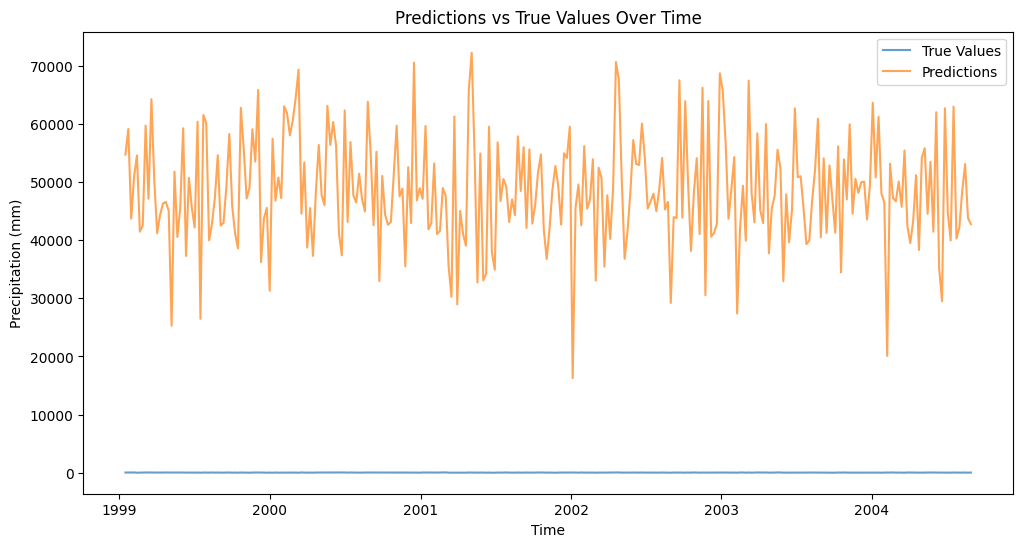

In [ ]:
import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from google.colab import drive
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

drive.mount('/content/drive/')
path = "/content/drive/My Drive/#IMPLEMENTASI/"

# Paths
pathout = path + "OUTPUT/"

# Read data
nc_forecast = xr.open_dataset(path + "CLIPPED_CFSV2_forecast_L1.nc")
nc_hindcast = xr.open_dataset(pathout + "CLIPPED_CFSV2_hindcast_L2.nc")
nc_chirps = xr.open_dataset(pathout + "CHIRPSPAPUA.nc")

# Align datasets
nc_chirps = nc_chirps.sel(X=slice(nc_forecast.X.min(), nc_forecast.X.max()), Y=slice(nc_forecast.Y.max(), nc_forecast.Y.min()))
nc_hindcast = nc_hindcast.rename({'S': 'T'})
nc_chirps = nc_chirps.sel(T=slice(nc_hindcast.T.min(), nc_hindcast.T.max()))

nc_chirps = nc_chirps.resample(T="7D").sum()
nc_hindcast = nc_hindcast.resample(T="7D").sum()

nc_chirps['prcp'] = nc_chirps['prcp'].fillna(0)
nc_hindcast['pr'] = nc_hindcast['pr'].fillna(0)
nc_hindcast['pr'] = nc_hindcast['pr']

# Prepare data for training and testing
data1 = nc_chirps['prcp'].values.reshape((nc_chirps.dims['T'], 1, nc_chirps.dims['Y'], nc_chirps.dims['X']))  # reanalysis
data2 = nc_hindcast['pr'].values.reshape((nc_hindcast.dims['T'], 1, nc_hindcast.dims['Y'], nc_hindcast.dims['X']))  # forecast lead1

print(f"data1 shape: {data1.shape}")
print(f"data2 shape: {data2.shape}")

scaler1 = StandardScaler()
scaler2 = StandardScaler()

data1 = scaler1.fit_transform(data1.reshape(data1.shape[0], -1)).reshape(data1.shape)
data2 = scaler2.fit_transform(data2.reshape(data2.shape[0], -1)).reshape(data2.shape)

X_train1, X_test1, y_train1, y_test1 = train_test_split(data2, data1, test_size=0.3, random_state=10)

# Convert to PyTorch tensors
X_train1 = torch.tensor(X_train1, dtype=torch.float32)
X_test1 = torch.tensor(X_test1, dtype=torch.float32)
y_train1 = torch.tensor(y_train1, dtype=torch.float32)
y_test1 = torch.tensor(y_test1, dtype=torch.float32)

# Create DataLoader with a smaller batch size
train_dataset = TensorDataset(X_train1, y_train1)
test_dataset = TensorDataset(X_test1, y_test1)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Smaller batch size
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define the CNN model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Calculate the size of the flattened feature map
        self._to_linear = None
        self.convs(torch.randn(1, 1, nc_chirps.dims['Y'], nc_chirps.dims['X']))
        self.fc1 = nn.Linear(self._to_linear, 128)
        # Adjust the output size of fc2 to match the desired reshaped size
        self.fc2 = nn.Linear(128, 1 * nc_chirps.dims['Y'] * nc_chirps.dims['X'])

    def convs(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        if self._to_linear is None:
            self._to_linear = x[0].numel()
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        # Reshape to the correct dimensions
        x = x.view(x.size(0), 1, nc_chirps.dims['Y'], nc_chirps.dims['X'])
        return x

model = ConvNet()

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model with minimal epochs
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Save the model
model_path = f'{path}model.pth'
torch.save(model.state_dict(), model_path)

# Load the model
model.load_state_dict(torch.load(model_path))
model.eval()

# Make predictions on the test data
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        predictions.append(outputs.numpy())

predictions = np.vstack(predictions)

# Optionally, convert predictions back to xarray DataArray
predictions = scaler2.inverse_transform(predictions.reshape(predictions.shape[0], -1)).reshape(predictions.shape)
predictions = predictions.reshape((len(predictions), nc_chirps.dims['Y'], nc_chirps.dims['X']))

# Create DataArray for predictions
predictions_da = xr.DataArray(predictions, dims=('T', 'Y', 'X'), coords={'T': nc_hindcast.T[:len(predictions)], 'Y': nc_hindcast.Y, 'X': nc_hindcast.X})

# Convert DataArray to Dataset
predictions_ds = predictions_da.to_dataset(name='prcp')

# Save the Dataset as a NetCDF file
output_path = f'{pathout}predictions.nc'
predictions_ds.to_netcdf(output_path)

# Evaluate the model
y_test_inv = scaler1.inverse_transform(y_test1.numpy().reshape(-1, nc_chirps.dims['Y'] * nc_chirps.dims['X']))
y_pred_inv = scaler2.inverse_transform(predictions.reshape(-1, nc_chirps.dims['Y'] * nc_chirps.dims['X']))

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
correlation = np.corrcoef(y_test_inv.flatten(), y_pred_inv.flatten())[0, 1]

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'Correlation: {correlation}')

# Plot the predictions and true values over time
time_index = nc_hindcast.T[:len(predictions)]
plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test_inv.mean(axis=1), label='True Values', alpha=0.7)
plt.plot(time_index, y_pred_inv.mean(axis=1), label='Predictions', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.title('Predictions vs True Values Over Time')
plt.legend()
plt.show()


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
data1 shape: (979, 1776)
data2 shape: (979, 1776)
Epoch [1/100], Loss: 0.4753
Epoch [2/100], Loss: 0.4748
Epoch [3/100], Loss: 0.4733
Epoch [4/100], Loss: 0.4712
Epoch [5/100], Loss: 0.4677
Epoch [6/100], Loss: 0.4658
Epoch [7/100], Loss: 0.4626
Epoch [8/100], Loss: 0.4582
Epoch [9/100], Loss: 0.4573
Epoch [10/100], Loss: 0.4485
Epoch [11/100], Loss: 0.4417
Epoch [12/100], Loss: 0.4366
Epoch [13/100], Loss: 0.4279
Epoch [14/100], Loss: 0.4223
Epoch [15/100], Loss: 0.4165
Epoch [16/100], Loss: 0.4134
Epoch [17/100], Loss: 0.4071
Epoch [18/100], Loss: 0.4029
Epoch [19/100], Loss: 0.3985
Epoch [20/100], Loss: 0.3958
Epoch [21/100], Loss: 0.3912
Epoch [22/100], Loss: 0.3905
Epoch [23/100], Loss: 0.3869
Epoch [24/100], Loss: 0.3835
Epoch [25/100], Loss: 0.3836
Epoch [26/100], Loss: 0.3811
Epoch [27/100], Loss: 0.3794
Epoch [28/100], Loss: 0.3773
Epoch [29/100], 

<ipython-input-39-34c8c9f8f251>:146: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100


RMSE: 312.0281066894531
MAE: 166.48898315429688
Correlation: 0.1909866500508535


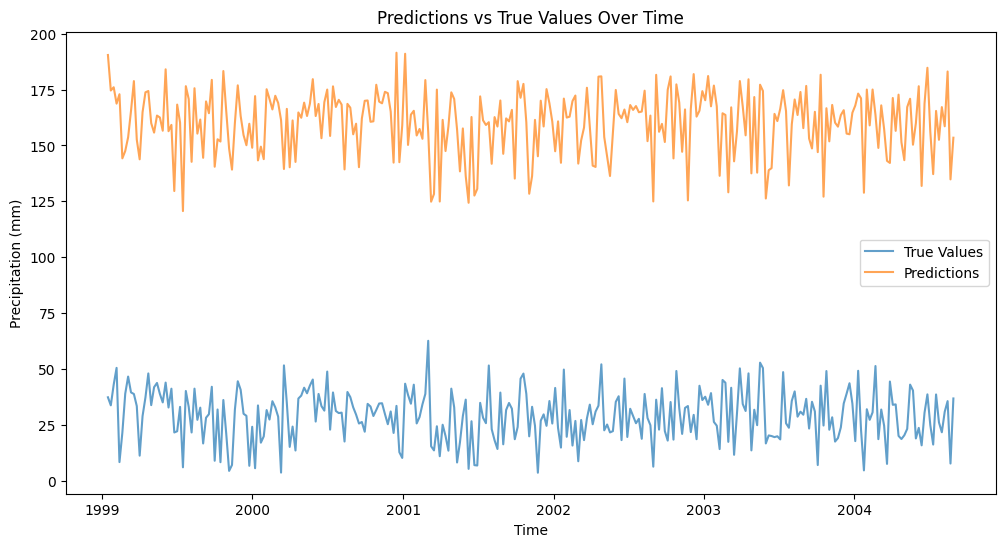

In [ ]:
import xarray as xr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

drive.mount('/content/drive/')
path="/content/drive/My Drive/#IMPLEMENTASI/"

# Paths
#path = os.getcwd() + "/"
pathout =path+ "OUTPUT/"
#pathinp = path + "input/"

# Read data
nc_forecast = xr.open_dataset(path + "CLIPPED_CFSV2_forecast_L1.nc")
nc_hindcast = xr.open_dataset(pathout + "CLIPPED_CFSV2_hindcast_L2.nc")
nc_chirps = xr.open_dataset(pathout + "CHIRPSPAPUA.nc")

# Align datasets
nc_chirps = nc_chirps.sel(X=slice(nc_forecast.X.min(), nc_forecast.X.max()), Y=slice(nc_forecast.Y.max(), nc_forecast.Y.min()))
nc_hindcast = nc_hindcast.rename({'S': 'T'})
nc_chirps = nc_chirps.sel(T=slice(nc_hindcast.T.min(), nc_hindcast.T.max()))

nc_chirps=nc_chirps.resample(T="7D").sum()
nc_hindcast=nc_hindcast.resample(T="7D").sum()
#nc_hindcast=nc_hindcast.sel(T=nc_hindcast["T.month"]==5)
#nc_chirps=nc_chirps.sel(T=nc_chirps["T.month"]==5)


nc_chirps['prcp'] = nc_chirps['prcp'].fillna(0)
nc_hindcast['pr'] = nc_hindcast['pr'].fillna(0)
nc_hindcast['pr'] = nc_hindcast['pr']

# Prepare data for training and testing
data1 = nc_chirps['prcp'].values.reshape((nc_chirps.dims['T'], -1))  # reanalysis
data2 = nc_hindcast['pr'].values.reshape((nc_hindcast.dims['T'], -1))  # forecast lead1


print(f"data1 shape: {data1.shape}")
print(f"data2 shape: {data2.shape}")

scaler1 = StandardScaler()
scaler2 = StandardScaler()

data1 = scaler1.fit_transform(data1)
data2 = scaler2.fit_transform(data2)

X_train1, X_test1, y_train1, y_test1 = train_test_split(data2, data1, test_size=0.3, random_state=10)

# Convert to PyTorch tensors
X_train1 = torch.tensor(X_train1, dtype=torch.float32)
X_test1 = torch.tensor(X_test1, dtype=torch.float32)
y_train1 = torch.tensor(y_train1, dtype=torch.float32)
y_test1 = torch.tensor(y_test1, dtype=torch.float32)

# Create DataLoader with a smaller batch size
train_dataset = TensorDataset(X_train1, y_train1)
test_dataset = TensorDataset(X_test1, y_test1)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Smaller batch size
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Simplified
        self.fc2 = nn.Linear(256, 64)         # Simplified
        self.fc3 = nn.Linear(64, input_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = X_train1.shape[1]
model = NeuralNetwork(input_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model with minimal epochs
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Save the model
model_path = f'{path}model.pth'
torch.save(model.state_dict(), model_path)

# Load the model
model.load_state_dict(torch.load(model_path))
model.eval()

# Make predictions on the test data
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        predictions.append(outputs.numpy())

predictions = np.vstack(predictions)

# Optionally, convert predictions back to xarray DataArray
#predictions = scaler2.inverse_transform(predictions)
predictions = predictions.reshape((len(predictions), nc_chirps.dims['Y'], nc_chirps.dims['X']))

# Create DataArray for predictions
predictions_da = xr.DataArray(predictions, dims=('T', 'Y', 'X'), coords={'T': nc_hindcast.T[:len(predictions)], 'Y': nc_hindcast.Y, 'X': nc_hindcast.X})

# Convert DataArray to Dataset
predictions_ds = predictions_da.to_dataset(name='prcp')

# Save the Dataset as a NetCDF file
output_path = f'{pathout}predictions.nc'
predictions_ds.to_netcdf(output_path)

# Evaluate the model
y_test_inv = scaler1.inverse_transform(y_test1.numpy().reshape(-1, nc_chirps.dims['Y'] * nc_chirps.dims['X']))
y_pred_inv = scaler2.inverse_transform(predictions.reshape(-1, nc_chirps.dims['Y'] * nc_chirps.dims['X']))

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100
correlation = np.corrcoef(y_test_inv.flatten(), y_pred_inv.flatten())[0, 1]

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
#print(f'MAPE: {mape}')
print(f'Correlation: {correlation}')

# Plot the predictions and true values over time
time_index = nc_hindcast.T[:len(predictions)]
plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test_inv.mean(axis=1), label='True Values', alpha=0.7)
plt.plot(time_index, y_pred_inv.mean(axis=1), label='Predictions', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')
plt.title('Predictions vs True Values Over Time')
plt.legend()
plt.show()
